In [9]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
import numpy as np
import matplotlib.pyplot as plt
import math
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
import seaborn as sns
from scipy.spatial.distance import pdist, squareform
import zipfile

In [10]:
z1 = zipfile.ZipFile('Data/Data No Outliers1.zip','r')
z2 = zipfile.ZipFile('Data/Data No Outliers2.zip','r')
data1 = pd.read_csv(z1.open('Data/Data No Outliers1.csv'))
data2 = pd.read_csv(z2.open('Data/Data No Outliers2.csv'))
data = pd.concat((data1,data2))

In [11]:
vars_for_cluster = ['B02','B03','B04','B05','B06','B07','B08','B8A','B09','B11','B12','Elevation','MSI','CRE',
                    'EVI','NDVI','GNDVI','MCARI','LAI','CC Red','CC Green','PSRI']

## Create the Principle Components <br>
In the EDA  notebook, the principle components yielded some dense clusters. Therefore, I would like to use them for the clustering, as well as for the reason that they cut the dimensionality in half. For the reasons stated in the EDA notebook, I am using MinMax Scaler.

In [12]:
#scaling the data using MinMax Scaler
scaling_minmax = MinMaxScaler()
scaling_minmax.fit(data[vars_for_cluster])
scaled_minmax = scaling_minmax.transform(data[vars_for_cluster])

In [13]:
#doing the PCA for the MinMax Scaled Data
pca_minmax = PCA(n_components = 13)
pca_minmax = pca_minmax.fit(scaled_minmax)
components_minmax = pca_minmax.transform(scaled_minmax)

## Clustering Algorithm Selection

Looking at the density plot of the first two principle components plotted against each other gives a good idea of what some of the clusters may be. For example, there is high density in the top of the plot, and there are a few islands of density in the lower portion of the plot. These high density areas are represented by the dark blue. However, I can also see that there is alot of noise around these high density areas. For example, all the dark blue is surrounded by substantially lighter shades of blue. Even more noise can be seen in the yellow shades surrounding the greater V shape of blue. Also, the clusters of high density are not spherically shaped, nor are they equal in size.<br>
In determing which model to use, I am considering the following:<br>
- <b>K-Means:</b> This algorithm would be good for a large data set such as this. However, K-Means is generally good for spherically shaped clusters. In this data, the clusters appear to be elliptical and if a sphere were fit to them, the clusters would be overlapping in places. K-Means also has trouble grouping data where the clusters are of varying sizes (which they appear to be here). Lastly, since all points must be put into a cluster in K-Means, the "noise" in our data will likely cause problems. Even though generalized K-Means models can be fit that are not bound to spherically shaped clusters, and soft clustering is available in K-Means, I don't think these will compensate for the other short comings of K-Means when applied to this data.<br>
- <b>Hierarchical Clustering: </b>This algorithm is complex in terms of time, so may not scale well to a large data set like this (although if the algorithm was the best fit for the data, I wouldn't let that be the deciding factor since this data set isn't enormous). Also, since the algorithm works by continueing to combine clusters based on the Euclidean distance, I am worried that it may not pick out the best clusters since this data appears to have clusters of densely packed points that span a large space, rather than clusters of points occurring in particular places in the dimension space. Also, the order of the data matters. This could be good because a pixels properties are likely to be similar to the pixels next to it. However, it may be difficult to represent these proximities in 2D space, when the proximities exist in 3D space. For example, a pixel that has pixels to the left or right will still have these pixels close by in the dataframe, but pixels above and below may be thousands of lines away in the dataframe. Lastly, Hierarchical Clustering is sensitive to outliers, and there are many outliers in this data.<br>
- <b>DBSCAN: </b>DBSCAN clusters based on the number of points within a specified radius rather than by the Euclidean distance between points. Since this data has many points close to each other spread across the dimensional space, a measure of density will work much better in finding clusters. This algorithm classifies each point as either a core point, border point, or a noise point, and only core points and border points are clustered. This allows the noisey points and outliers to not impact how the clusters form like in the K-Means and Hierarchical Clustering. Another advantage to K-Means is that DBSCAN doesn't assume spherical clusters. I am choosing DBSCAN as the clustering algorithm to apply to this data.

## Fine Tuning the MinPoints and Epsilon radius parameters

In [14]:
#general rule of thumb is to start with a min_pts value of twice the number of features
min_pts = len(components_minmax[0])*2

In [15]:
#writing the components to a dataframe to make using it easier down the notebook
comps = pd.DataFrame(components_minmax)

In [16]:
#then, I split up the data into equal parts - I need to do this because the DBSCAN algorithm requires ALOT of memory otherwise,
#which is not acheivable on this laptop (or any laptop probably) with a data set of this size (not even that large). I have
#chosen 50 splits because a dataframe of about 10,000 points yields a really good runtime per split
#I am adding in the 'i' and 'j' columns so that the locations of the points can be mapped in later use

In [17]:
splits = 50
combined = pd.concat((comps,data[['i','j']].reset_index(drop=True)),axis=1)
shuffled = combined.sample(frac=1)
result = np.array_split(shuffled, splits)

In [18]:
#i and j are only used for retrieving pixel location down the notebook and shouldn't be used in the clustering
to_use = list(combined.columns)
to_use.remove('i')
to_use.remove('j')

In [19]:
#putting the samples into their own dataframes
sh_dfs = []
for i in range(splits):
    temp = pd.DataFrame(result[i])
    temp = temp.reset_index(drop=True)
    sh_dfs.append(temp)

## Using the Min Points Value chosen, I'm finding out how far away in terms of Euclidean Distance from each point we must go in order to contain Min Points surrounding points

### Beware! This cell below takes a long time to run!

In [ ]:
ordered_eps = []

for i in range(splits):
    print(i)
    #creating the Euclidean Distance Matrix
    distances = pdist(sh_dfs[i][to_use].values, metric='euclidean')
    dist_matrix = squareform(distances)
    #looping through each point in the dataframe then sorting the euclidean distances in that row, and then finding the
    #the distance away from that point the 'min_pts-1'th point is
    eps = []
    for i in range(sh_dfs[i][to_use].shape[0]):
        idists = sorted(dist_matrix[i])
        eps.append(idists[min_pts-1])
    eps_ordered = sorted(eps,reverse=True)
    ordered_eps.append(eps_ordered)

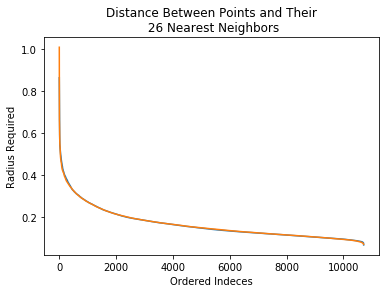

In [14]:
#looping through all the epsilon orderings done and plotting them all
for eps in ordered_eps[0:2]:
    plt.plot(range(len(eps)),eps)
plt.title('Distance Between Points and Their\n '+str(min_pts)+' Nearest Neighbors')
plt.xlabel('Ordered Indeces')
plt.ylabel('Radius Required')
plt.savefig('Epsilon Estimation.png')

## Now I'm going to run the DBSCAN algorithm on all of the splits individually <br>
Since the splits are done from a shuffled dataset, in theory, the density distributions should be relatively similar across all of the splits, meaning that the clusters found from performing DBSCAN on each split should roughly match what clusters would be found running DBSCAN on the whole data set as long as the epsilon and min points values are chosen according to the plot above based on the densities of the split dataframes. This is the best I can do given the memory issue when running DBSCAN

## Now to try out each value of epsilon and record the silhouette and cabrinski score at each iteration. This code takes a while to run, so I'm only incrementing epsilon every 0.025. <br>
On my Laptop, this took about 8-10 hours...so I wrote the output to csv files

I have chosen to explore epsilon values between 0.1 and 0.375 because these are the values contained in the 'elbow' of the plot above showing the minimum distance between any point and it's nearest 26 neighbors.

In [ ]:
all_groups = []
silhouettes = []
for epsilon in np.arange(0.1,0.4,0.025):
    print('Epsilon')
    print(epsilon)
    db = DBSCAN(eps=epsilon,
               min_samples=min_pts,
               metric='euclidean')
    core_sample_indeces = []
    all_labels = []
    groups = []
    for i in range(splits):
        #printing out i every time it loops through to gauge the progress
        print(i)
        db.fit(sh_dfs[i][to_use])
        #merge the groups with the existing groups
        groups = sat_utils.addGroups(groups, db.core_sample_indices_, db.labels_, sh_dfs[i], to_use, epsilon)
    
    #Assigning values and colors to each cluster and then record the values for that epsilon
    print('Models have been run')
    out_colors = np.array(['red','blue','green','yellow','purple','grey','black','orange','white'])
    j = 0
    group = groups[j]
    group['Group'] = j
    group['Color'] = out_colors[j]
    all_group = group
    for j in range(1,len(groups)):
        group = groups[j]
        group['Group'] = j
        group['Color'] = out_colors[j]
        all_group = all_group.append(group)
    all_groups.append(all_group)
    print('Calculating Metric')
    silhouettes.append(metrics.silhouette_score(all_group[to_use], all_group['Group'], metric='euclidean'))

### Writing the output to csv files

In [22]:
i = 0
for group in all_groups:
    group.to_csv('Data/Group'+str(i)+'DataFrame.csv')
    i+=1

In [23]:
sil_df = pd.DataFrame(silhouettes)
sil_df.to_csv('Silhouette Recordings.csv')

## Visually inspectig which epsilon value yields the highest model evaluation metric

In [20]:
silhouettes = list(pd.read_csv('Silhouette Recordings.csv')['0'])

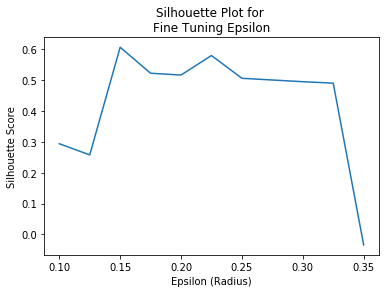

In [21]:
plt.plot(np.arange(0.1,0.375,0.025),silhouettes)
plt.xlabel('Epsilon (Radius)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Plot for \nFine Tuning Epsilon')
plt.savefig('Silhouette Plot.png')

<b>Silhouette Scores: </b>The highest value on the Silhouette plot is acheived with an epsilon of 0.15, which yields a score close to 0.6. This score suggests the cluster(s) are non-overlapping and strongly dense. The epsilon values ranging from 0.2 to 0.225, however, all yield silhouette scores of roughly 0.5 or higher and all sit between the two peaks of silhouette scores. I would like to plot the clusters as a function of the first two principle components for the epsilon values 0.15 through 0.225. They are seen below.<br>

## Visualizing the Clusters as a function of the first two principle components

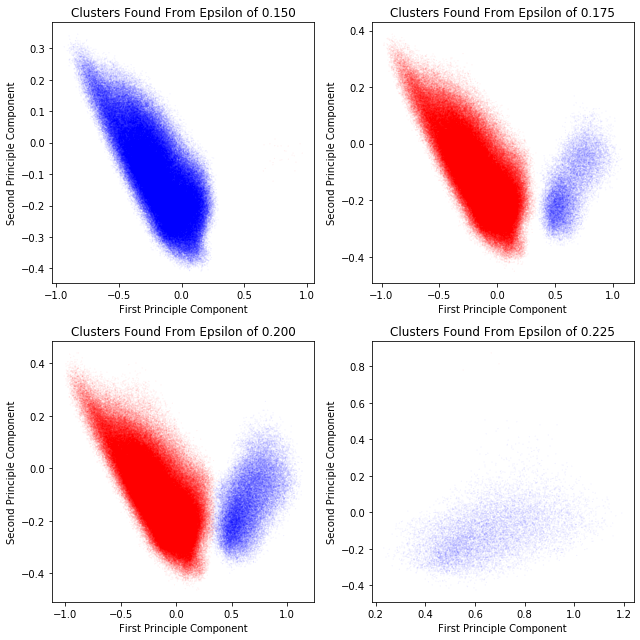

In [22]:
fig,ax = plt.subplots(2,2)
fig.set_size_inches(9,9)
for i in range(2,6):
    selected = pd.read_csv('Data/Group'+str(i)+'DataFrame.csv')
    ax[int((i-2)/2),(i-2)%2].scatter(selected['0'],selected['1'],c=selected['Color'],s=0.0005)
    ax[int((i-2)/2),(i-2)%2].set_title('Clusters Found From Epsilon of '+ "%.3f"%list(np.arange(0.15,0.25,0.025))[i-2])
    ax[int((i-2)/2),(i-2)%2].set_xlabel('First Principle Component')
    ax[int((i-2)/2),(i-2)%2].set_ylabel('Second Principle Component')
#fig.savefig('Clustering Plot.png')
fig.tight_layout()

Notes on the clustering above:<br>
- <b>Epsilon of 0.15:</b> This doesn't really have two clusters. Most of the points were bucketted into the noise group. This clustering is not good for this data. Even though this yielded the highest silhouette score, it is not the best epsilon value.<br>
- <b>Epsilon of 0.175:</b> This clustering looks pretty good. The two groups are separated and dense.<br>
- <b>Epsilon of 0.2:</b> This clustering also looks pretty good. The two groups are not separated as nicely as with epsilon of 0.175, but the blue cluster is more dense and larger.
- <b>Epsilon of 0.225:</b> This cluster result looks pretty awful.<br><br>
- <b> Conclusion:</b> I am concluding that the clusters yielded from an epsilon value of 0.2 are the strongest. This will be my clustering model of choice - DBSCAN with min points of 26 and epsilon of 0.2.

## Visualizing what the clusters are associated with on the image

In [23]:
selected = pd.read_csv('Data/Group4DataFrame.csv')

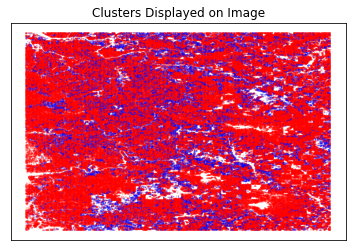

In [24]:
fig,ax=plt.subplots(1)
ax.scatter(selected['j'],selected['i'],c=selected['Color'],s=0.01)
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
ax.set_title('Clusters Displayed on Image')
fig.savefig('Clusters On Image.png')

## Figure out what type of values the raw clusters are associated with

In [25]:
#creating a dataframe per cluster
cluster1 = selected[selected['Group']==0]
cluster2 = selected[selected['Group']==1]

In [26]:
#using the i and j columns to map the clusters to the original dataset (raw data not principle components)
data['i&j'] = data['i'].astype(str) + ' '+data['j'].astype(str)

cluster1['i&j'] = cluster1['i'].astype(str) + ' '+cluster1['j'].astype(str)
cluster2['i&j'] = cluster2['i'].astype(str) + ' '+cluster2['j'].astype(str)

raw_values_cluster1 = data[data['i&j'].isin(cluster1['i&j'])]
#raw_values_cluster1['Group'] = [0]*raw_values_cluster1.shape[0]
raw_values_cluster2 = data[data['i&j'].isin(cluster2['i&j'])]
#raw_values_cluster2['Group'] = [0]*raw_values_cluster2.shape[0]

#all_clusters = pd.concat((raw_values_cluster1,raw_values_cluster2))

C:\Users\david\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
C:\Users\david\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


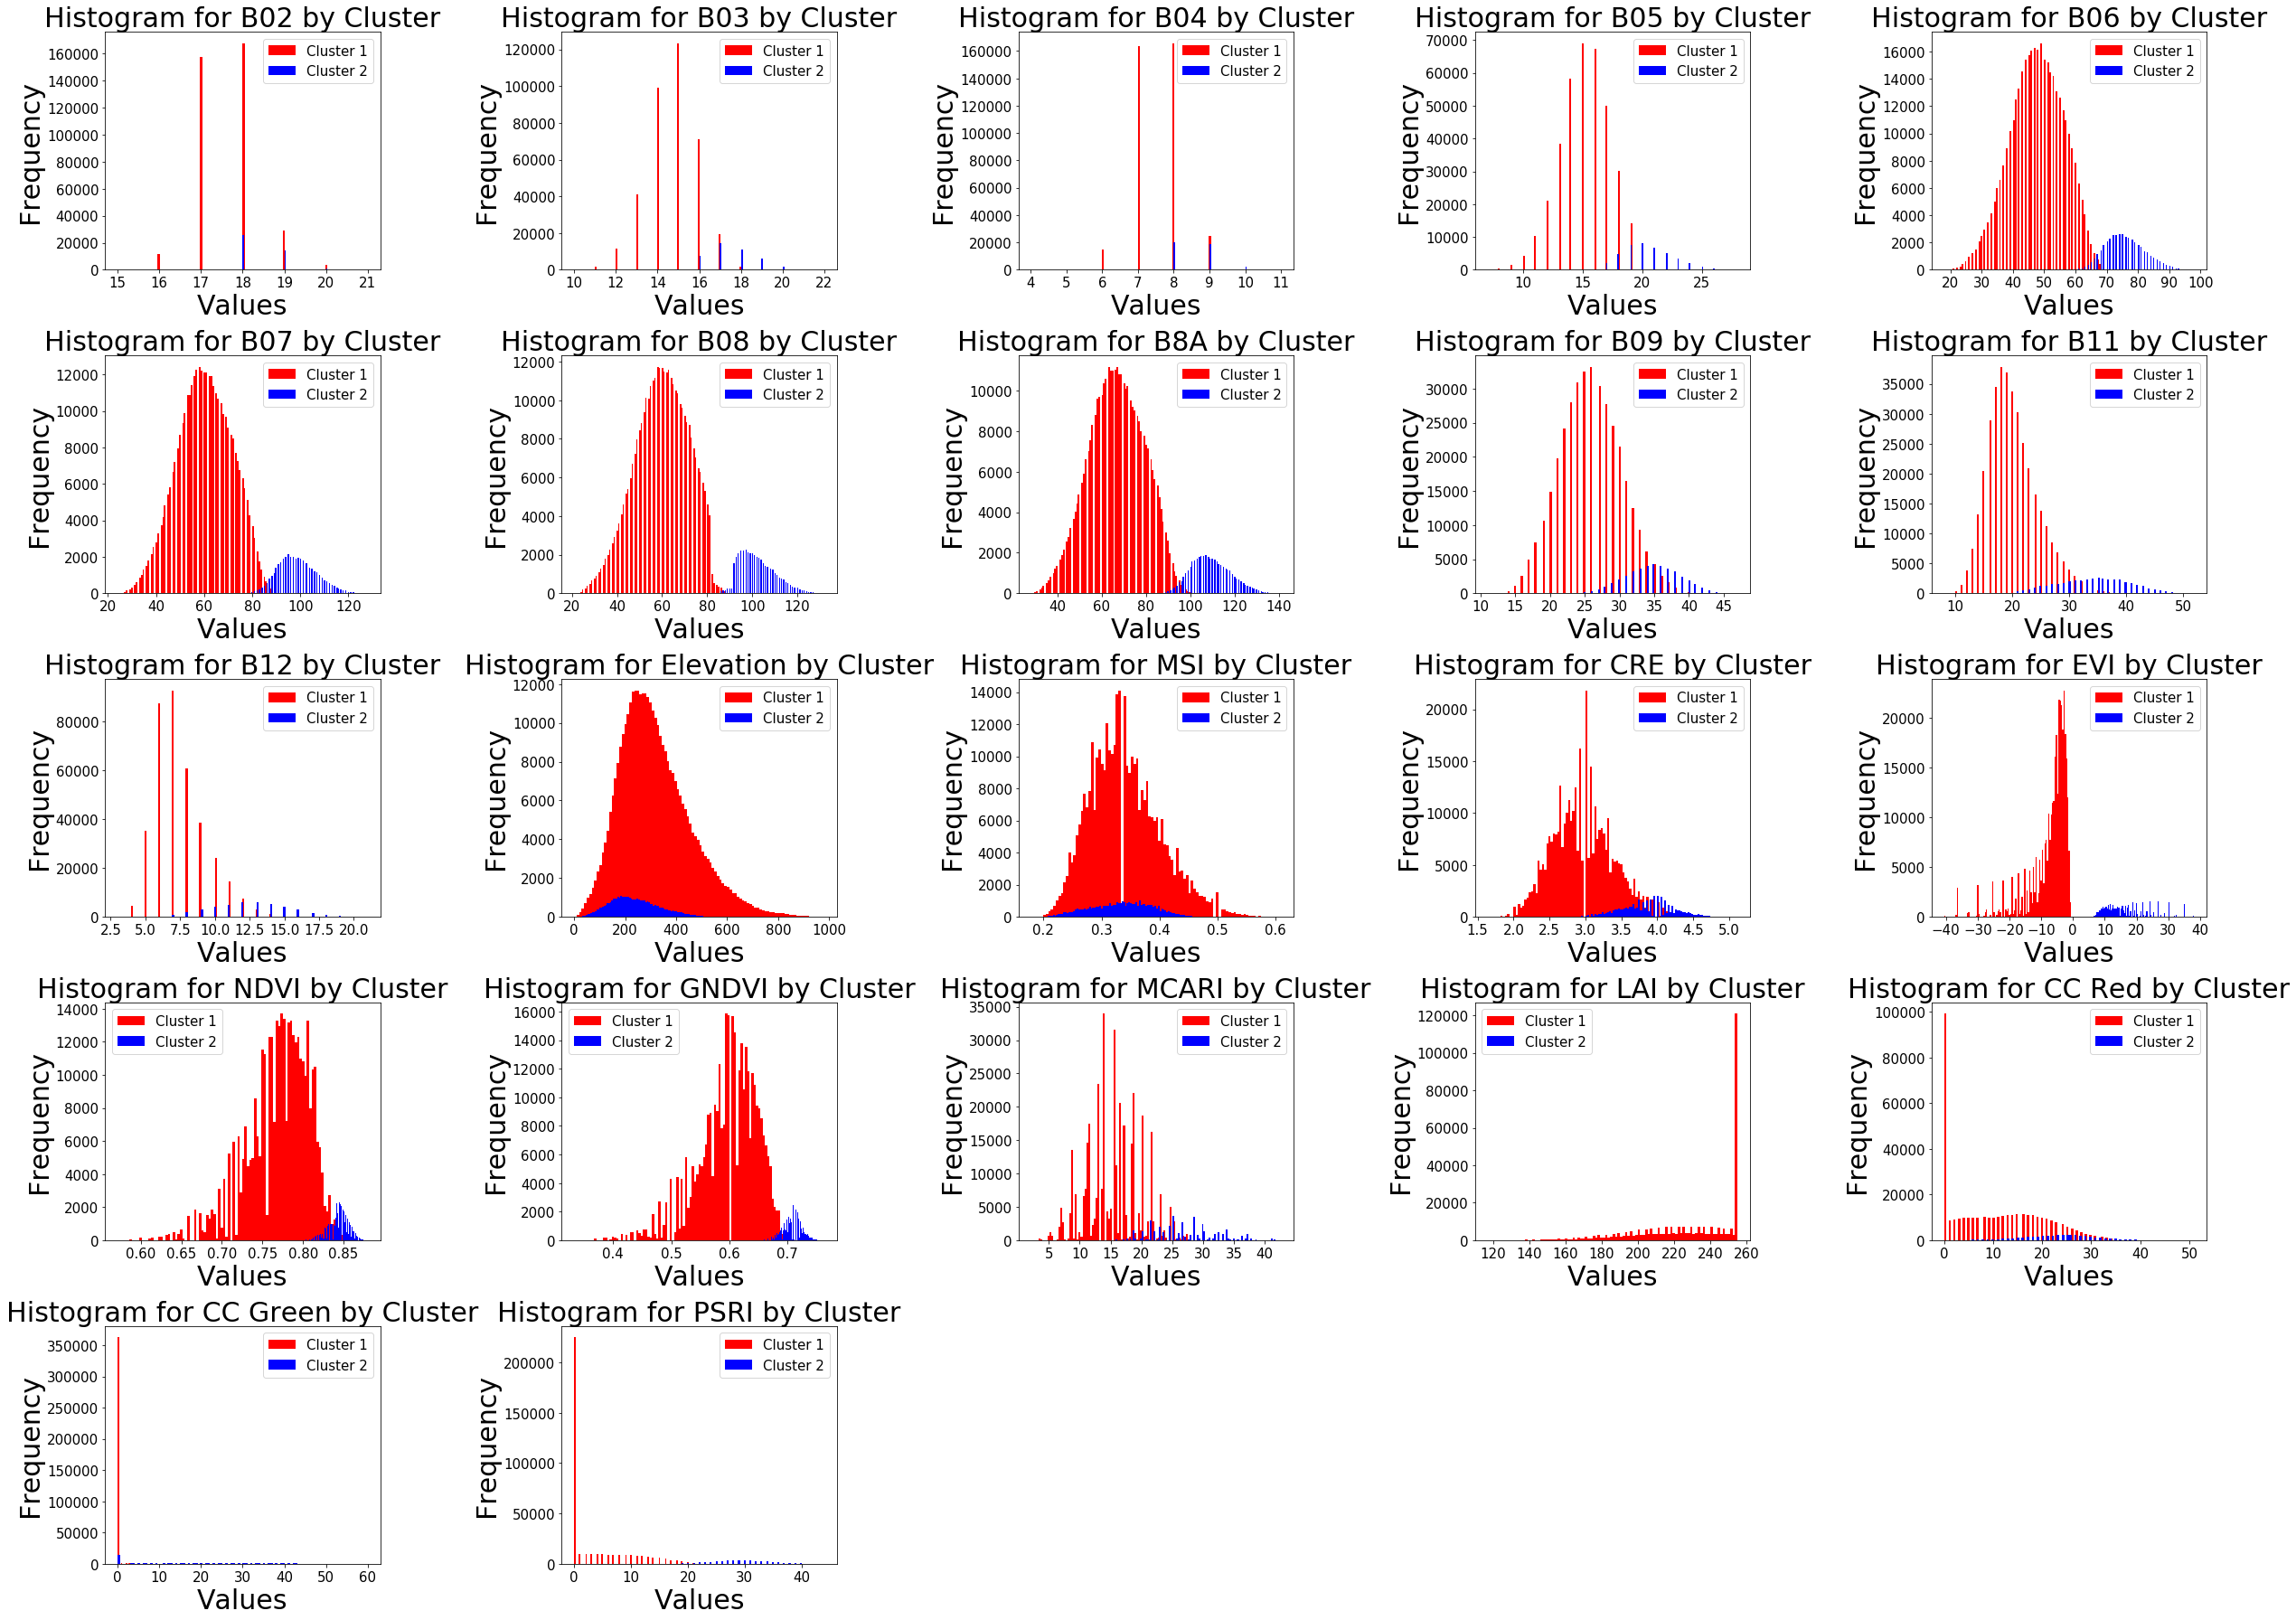

In [27]:
fig, ax = plt.subplots(5,5)
fig.set_size_inches(35,25)

for i in range(len(vars_for_cluster)):
    ax[int(i/5),i%5].hist(raw_values_cluster1[vars_for_cluster[i]],bins=100,color='Red',label='Cluster 1')
    ax[int(i/5),i%5].hist(raw_values_cluster2[vars_for_cluster[i]],bins=100,color='Blue',label='Cluster 2')
    ax[int(i/5),i%5].set_title('Histogram for '+vars_for_cluster[i]+' by Cluster',fontsize=30)
    ax[int(i/5),i%5].set_xlabel('Values',fontsize=30)
    ax[int(i/5),i%5].set_ylabel('Frequency',fontsize=30)
    for tick in ax[int(i/5),i%5].xaxis.get_major_ticks():
        tick.label.set_fontsize(15) 
    for tick in ax[int(i/5),i%5].yaxis.get_major_ticks():
        tick.label.set_fontsize(15) 
    ax[int(i/5),i%5].legend(fontsize=15)
    
ax[4,2].axis('off')
ax[4,3].axis('off')
ax[4,4].axis('off')
fig.savefig('Clusters Explained.png')
fig.tight_layout()


## Conclusions on the Clusters

### High Level Description

<b>Cluster 1: </b>This is the main cluster (red). It has a lot more points belonging to it than that second cluster has. It typically has lower values for the B03, B05, B06, B07, B08, B8A, B09,B11, and B12 bands as well as the CRE, EVI, NDVI, GNDVI, MCARI, and PSRI indices. When looking at the distributions in the EDA file, I had pointed out that many of the feature distributions appear to have a large frequency mode, and a lower frequency mode on the distributions way down to the right. This cluster appears to belong to the underlying distribution of the high frequency mode.<br>
<b>Cluster 2:</b> This is the smaller cluster (blue). It has a lot less points belonging to it than the first cluster has. For all the bands and indices for which the first cluster typically has lower values, this cluster tends to have higher values. For the features pointed out in the EDA file with the 'humps' or lower frequency modes, it appears as if this cluster belongs to the underlying distributions of these low frequency modes. 

### Further Description

In [28]:
summary = pd.DataFrame({'Cluster 1 Means':raw_values_cluster1[vars_for_cluster].describe().loc['mean',:].T,
                       'Cluster 1 Medians':raw_values_cluster1[vars_for_cluster].describe().loc['50%',:].T,
                       'Cluster 2 Means':raw_values_cluster2[vars_for_cluster].describe().loc['mean',:].T,
                       'Cluster 2 Medians':raw_values_cluster2[vars_for_cluster].describe().loc['50%',:].T})

In [29]:
summary

,Cluster 1 Means,Cluster 1 Medians,Cluster 2 Means,Cluster 2 Medians
B02,17.608418,18.000000,18.395165,18.000000
B03,14.704126,15.000000,17.492089,17.000000
B04,7.544541,8.000000,8.578419,9.000000
B05,15.180752,15.000000,20.454885,20.000000
B06,47.658371,48.000000,75.742192,75.000000
B07,60.338665,60.000000,98.758663,98.000000
B08,59.798963,60.000000,102.236810,101.000000
B8A,66.771793,67.000000,109.326390,109.000000
B09,25.826743,26.000000,34.854288,35.000000
B11,20.094499,19.000000,34.249500,34.000000


The green values (B03) are about 3 units smaller than that of the second cluster on average. This means the trees in cluster 1 tend to be a lighter shade of green. <br>
The bands that have to do with Vegetation Red Edge (B05, B06, and B07) are between 25% and 38% lower than those of the second cluster on average. This means the trees in cluster 1 are reflecting less light in the infrared red spectrum than those in cluster 2. Since B08 and B8A measure near infrared and narrow infrared reflectance, this explains the lower values on average for these bands in cluster 1 as well. In general, deciduous tree tend to reflect more light in the infrared red spectrum. <br>
Cluster 1 has values for the B09, B11, and B12 bands that are roughly 28% to 42% lower than those in cluster 2. These three bands reflect the levels of moisture in the vegetation and soil. This suggests that trees in cluster 1 are living in a drier environment compared to cluster 2. <br>
The median values for the vegetation indices (NDVI, GNDVI, and EVI) are lower in cluster 1 than those in cluster 2. This implies that cluster 2 provides a more lush environment. The mean NDVI for cluster 2 is 0.84, and the values get as high as 0.88. A value of 1 is associated with a tropical rainforest, so these values may indicate an environment similar to a temperate rainforest.<br>
The Chlorophyll Red Edge (CRE) is 23% lower on average in cluster 1. CRE indicates the ammount of chlorophyll on the ground. A higher value on average within cluster 2 suggests there is more lush undergrowth in cluster 2. <br>
Cluster 1 has lower MCARI values than cluster 2 on average (44% lower on average). This suggests the canopy in cluster 2 is more dense on average. This agrees with the differences between Leaf Area Index (LAI) distributions across the two clusters. The average LAI for the first cluster is 10% lower than that of the second cluster.<br>
The Plant Senescence Reflectance Index (PSRI) levels in the second cluster are much higher on average than in the first cluster. PSRI is usually used to indicate the health of a forest. This suggest the trees in the second cluster are healthier.<br>
Lastly, it is also important to note that the elevations found in cluster 1 range from 0 meters above sea level to as high as over 900 meters. The elevations for cluster 2, however, only range from 0 to roughly 500 meters above sea level.

### Overall Conclusion

After [reading](https://oregonwild.org/siuslaw-national-forest#:~:text=The%20trees%20in%20the%20Siuslaw,and%20Big%20leaf%20Maple%20trees.) up about the trees in the region this data is from (Siuslaw National Forest), I found that this area is made up of Sitka Spruce (coniferous) near the coast, and Douglas Fir and Western Hemlock (coniferous) growing inland. Trees growing near rivers and streams consist mainly of Red Alder and Big Leaf Maple (both deciduous) as well as Western Red Cedar (coniferous). Other deciduous trees that can be found in this area are oak, madrone, and ash. <br>
Since deciduous trees tend to grow in areas surrounding streams, I think cluster 2 may be associated with areas containing majority deciduous trees. This would exlain the higher infrared red reflection ratios (as explained above), higher canopy moisture levels (more moisture near streams), and the thicker, more vegetated unergrowth and canopy (water sources usually produce more plant life, and healthier plant life). This would also explain the small size of cluster 2, because most of the forests in this area are dominated by the coniferous Douglas Fir and Western Hemlock.<br>
The only way to really know what these clusters represent is to compare these clustered areas to tree survey reports. Once compared with such data, this clustering may be useful for the timber company prospecting potential timber plots in predicting the species of trees contained in the plot.